# Введение


Музыкальный стриминговый сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами. В связи с этим возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы.

В данном исследовании будет проанализирован датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры.

Задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

# Обработка данных

## Загрузка библиотек

In [1]:
!pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


In [2]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 1.2 MB/s eta 0:00:01     |████████████████████            | 19.2 MB 1.2 MB/s eta 0:00:10
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [3]:
!pip install catboost

In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from catboost import CatBoost
from sklearn.preprocessing import LabelEncoder
#from google.colab import files
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

## Загрузка и ознакомление с данными

Загрузим тренировочный датасет.

In [5]:
df_full = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRDDAAQ95Yc123yzPRDOzkGT7_zCMl_52OzikUJk4mwrLBvGlKTZxjsO5vrzNClh7tgIJWGTC7JwtXc/pub?gid=974732063&single=true&output=csv', sep=',')
df_full.head()

instance_id                  track_name  acousticness  danceability  \
0      25143.0                  Highwayman        0.4800         0.670   
1      26091.0       Toes Across The Floor        0.2430         0.452   
2      87888.0       First Person on Earth        0.2280         0.454   
3      77021.0  No Te Veo - Digital Single        0.0558         0.847   
4      20852.0             Chasing Shadows        0.2270         0.742   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0     182653.0   0.351          0.017600   D     0.115   -16.842  Major   
1     187133.0   0.670          0.000051   A     0.108    -8.392  Minor   
2     173448.0   0.804          0.000000   E     0.181    -5.225  Minor   
3     255987.0   0.873          0.000003  G#     0.325    -4.805  Minor   
4     195333.0   0.575          0.000002   C     0.176    -5.550  Major   

   speechiness    tempo obtained_date  valence  music_genre  
0       0.0463  101.384         4-Apr    0.450      Country  
1       0.0352  113.071         4-Apr    0.539         Rock  
2       0.3710   80.980         4-Apr    0.344  Alternative  
3       0.0804  116.007         4-Apr    0.966      Hip-Hop  
4       0.0487   76.494         4-Apr    0.583  Alternative

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

Всего 15 признаков и 20394 наблюдений. Пропущенные значения есть в трех переменных (расммотрим заполнение пропусков в следующем разделе).

Загрузим тестовый датасет.

In [7]:
df_test = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRK28C35dCvCWKDv-8Ee7MbXZjsHHn-VMPFn_9xG3ckkkF_U3nSn4l1pPvdf6eGctwXZrTzqRSL8X4w/pub?output=csv', sep=',')
df_test.head()

instance_id            track_name  acousticness  danceability  duration_ms  \
0        48564  Low Class Conspiracy      0.301000         0.757     146213.0   
1        72394            The Hunter      0.538000         0.256     240360.0   
2        88081           Hate Me Now      0.005830         0.678     284000.0   
3        78331    Somebody Ain't You      0.020300         0.592     177354.0   
4        72636            Sour Mango      0.000335         0.421         -1.0   

   energy  instrumentalness key  liveness  loudness   mode  speechiness  \
0   0.679           0.00000  A#    0.3030    -7.136  Minor       0.3560   
1   0.523           0.00832  G#    0.0849    -5.175  Major       0.0294   
2   0.770           0.00000   A    0.1090    -4.399  Minor       0.2220   
3   0.749           0.00000   B    0.1220    -4.604  Major       0.0483   
4   0.447           0.01480   D    0.0374    -8.833  Major       0.2020   

     tempo obtained_date  valence  
0   90.361         4-Apr    0.895  
1   78.385         4-Apr    0.318  
2   90.000         4-Apr    0.412  
3  160.046         4-Apr    0.614  
4   73.830         4-Apr    0.121

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


In [9]:
#сохраним идентификатор трека в тестовом наборе
df_test_id = df_test['instance_id']

## Создание новых признаков



В базах есть столбец с названиями треков. Они уникальны и в числовой вид перекодировать будет трудно. Создадим новую переменную с количеством симоволов в названии трека.

In [10]:
#кол-во символов в названии трека
df_full['symbol_count'] = df_full['track_name'].apply(lambda x: len(x))


In [11]:
#кол-во символов в названии трека
df_test['symbol_count'] = df_test['track_name'].apply(lambda x: len(x))

## Отбор финального набора обучающих признаков

Рассмотрим переменную 'obtained_date' - когда были загружены треки.

In [12]:
df_full['obtained_date'].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr'], dtype=object)

В переменной содержатся данные только за 4 дня. Так как они идут подряд, то существенной информации не несут. Далее удалим эту переменную из анализа.

Также не понадобятся данные о клиентском id, полном названии треков.

Финальный вариант данных в обучающей выборке:

In [13]:
df = df_full.loc[:, 'acousticness':'symbol_count']

df = df.drop('obtained_date', axis= 1)
df.head()

acousticness  danceability  duration_ms  energy  instrumentalness key  \
0        0.4800         0.670     182653.0   0.351          0.017600   D   
1        0.2430         0.452     187133.0   0.670          0.000051   A   
2        0.2280         0.454     173448.0   0.804          0.000000   E   
3        0.0558         0.847     255987.0   0.873          0.000003  G#   
4        0.2270         0.742     195333.0   0.575          0.000002   C   

   liveness  loudness   mode  speechiness    tempo  valence  music_genre  \
0     0.115   -16.842  Major       0.0463  101.384    0.450      Country   
1     0.108    -8.392  Minor       0.0352  113.071    0.539         Rock   
2     0.181    -5.225  Minor       0.3710   80.980    0.344  Alternative   
3     0.325    -4.805  Minor       0.0804  116.007    0.966      Hip-Hop   
4     0.176    -5.550  Major       0.0487   76.494    0.583  Alternative   

   symbol_count  
0            10  
1            21  
2            21  
3            26  
4            15

В тестовой:

In [14]:
#удаляем лишние столбцы

df_test = df_test.loc[:, 'acousticness':'symbol_count']

df_test = df_test.drop('obtained_date', axis= 1)
df_test.head()

acousticness  danceability  duration_ms  energy  instrumentalness key  \
0      0.301000         0.757     146213.0   0.679           0.00000  A#   
1      0.538000         0.256     240360.0   0.523           0.00832  G#   
2      0.005830         0.678     284000.0   0.770           0.00000   A   
3      0.020300         0.592     177354.0   0.749           0.00000   B   
4      0.000335         0.421         -1.0   0.447           0.01480   D   

   liveness  loudness   mode  speechiness    tempo  valence  symbol_count  
0    0.3030    -7.136  Minor       0.3560   90.361    0.895            20  
1    0.0849    -5.175  Major       0.0294   78.385    0.318            10  
2    0.1090    -4.399  Minor       0.2220   90.000    0.412            11  
3    0.1220    -4.604  Major       0.0483  160.046    0.614            18  
4    0.0374    -8.833  Major       0.2020   73.830    0.121            10

В разделе обучения моделей была проанализирована важность признаков. Не все признаки внесли одинаковый вклад в построении модели. Тем не менее, удаление менее важных признаков не привело к улучшению качества моделей (даже немного его ухудшило). Поэтому этот набор признаков является финальным.

## Обработка выбросов

Рассмотрим каждую переменную - ее распределение, обработаем аномальные значения.

### acousticness

AxesSubplot(0.125,0.125;0.775x0.755)
count    20394.000000
mean         0.274783
std          0.321643
min          0.000000
25%          0.015200
50%          0.120000
75%          0.470000
max          0.996000
Name: acousticness, dtype: float64


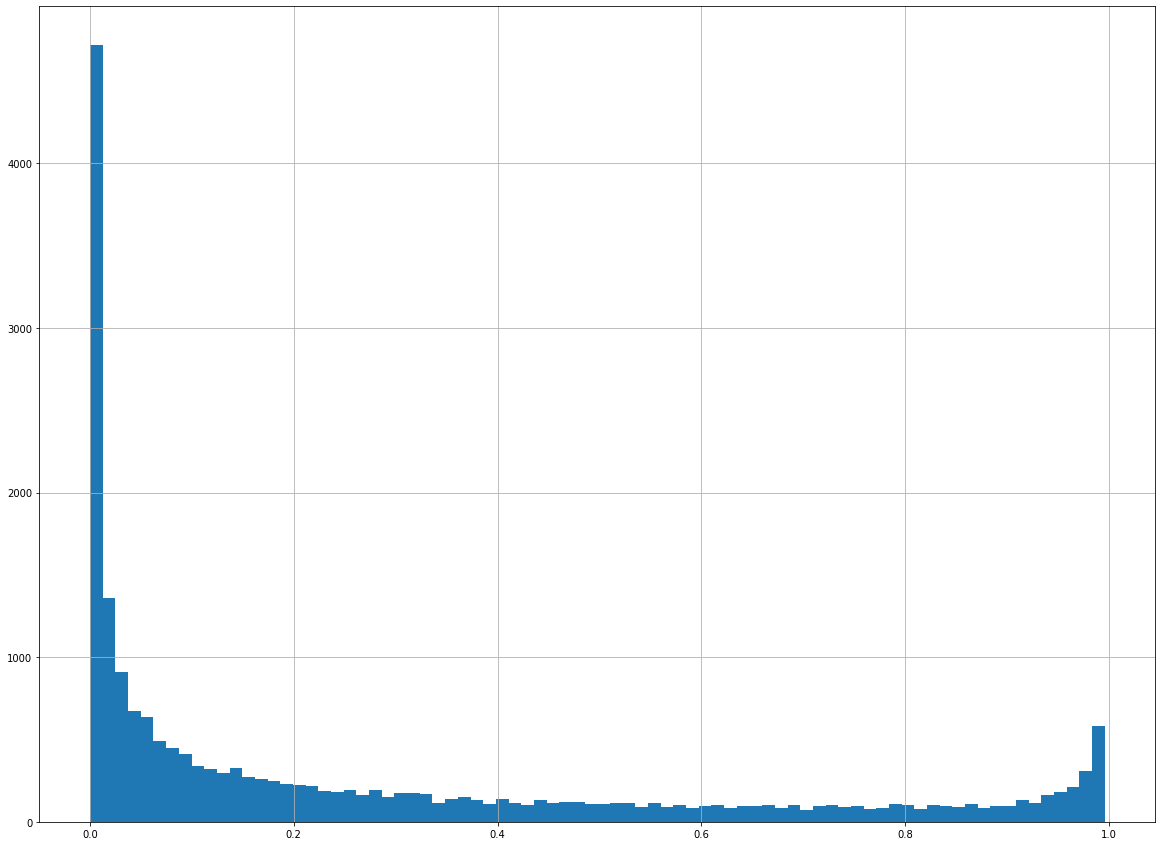

In [15]:
print(df['acousticness'].hist(bins=80, figsize=(20, 15)))
print(df['acousticness'].describe())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f62da8c7760>,
 'caps': [<matplotlib.lines.Line2D at 0x7f62da8c7e20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f62da8c7400>],
 'medians': [<matplotlib.lines.Line2D at 0x7f62da8d7520>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f62da8d7880>],
 'means': []}

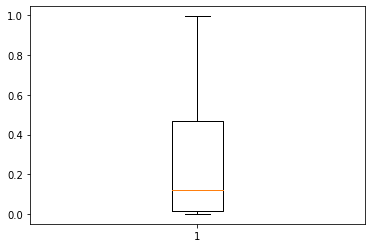

In [16]:
plt.boxplot(x=df['acousticness'])

Значения изменяются в промежутке от 0 до 1. Резких и выбивающихся значений нет, переменную трогать не будем.

### danceability

AxesSubplot(0.125,0.125;0.775x0.755)
count    20394.000000
mean         0.561983
std          0.171898
min          0.060000
25%          0.451000
50%          0.570000
75%          0.683000
max          0.978000
Name: danceability, dtype: float64


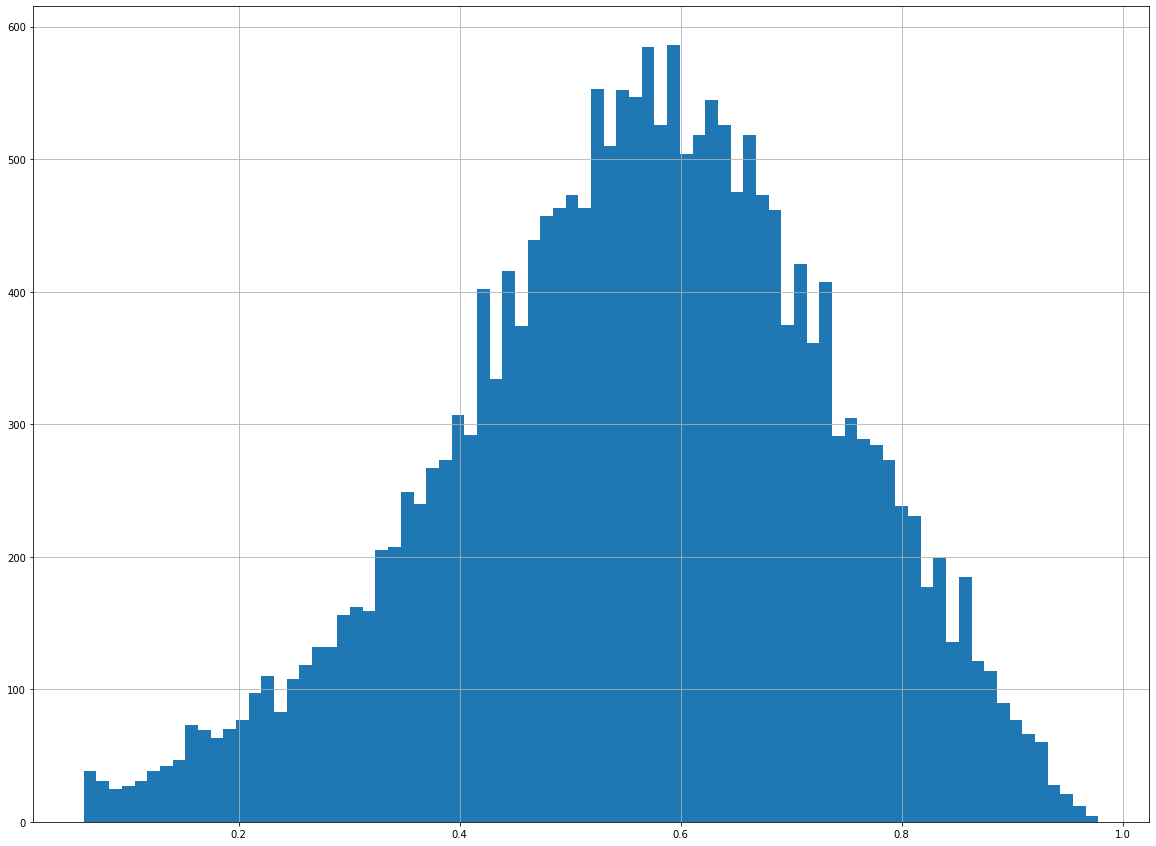

In [17]:
print(df['danceability'].hist(bins=80, figsize=(20, 15)))
print(df['danceability'].describe())

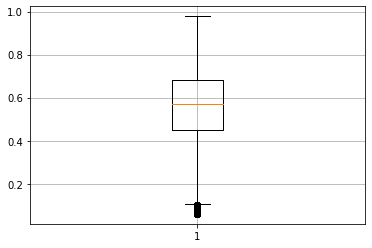

In [18]:
plt.boxplot(x=df['danceability'])
plt.grid(True)

Танцевальность - тут также значения находятся в промежутке от 0 до 1, причем значения, близкие к нулю выходят за пределы "усов". Выбросов немного, они находятся близко к "усам", поэтому оставляем все как есть.

### duration_ms

AxesSubplot(0.125,0.125;0.775x0.755)
count    2.039400e+04
mean     2.203754e+05
std      1.267283e+05
min     -1.000000e+00
25%      1.775170e+05
50%      2.195330e+05
75%      2.660000e+05
max      4.497994e+06
Name: duration_ms, dtype: float64


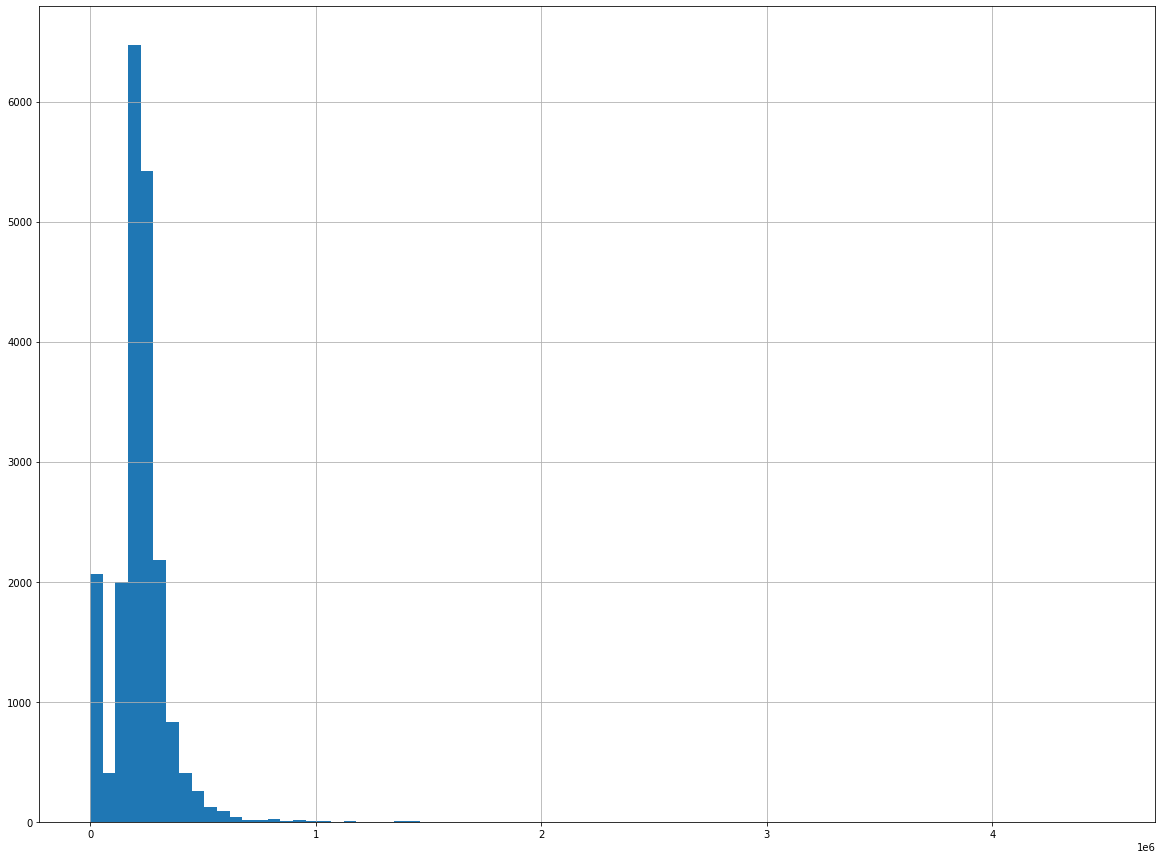

In [19]:
print(df['duration_ms'].hist(bins=80, figsize=(20, 15)))
print(df['duration_ms'].describe())

(200000.0, 2000000.0)

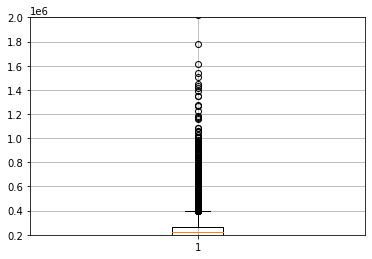

In [20]:
plt.boxplot(x=df['duration_ms'])
plt.grid(True)
plt.ylim(200000, 2000000)

In [21]:
df.query('duration_ms > 400000').count()

acousticness        954
danceability        954
duration_ms         954
energy              954
instrumentalness    954
key                 925
liveness            954
loudness            954
mode                928
speechiness         954
tempo               938
valence             954
music_genre         954
symbol_count        954
dtype: int64

In [22]:
#заменим -1 на медиану
df.loc[df['duration_ms'] < 0 , 'duration_ms'] = df['duration_ms'].median()

#удалим очень длинные треки
df = df.query('duration_ms < 1000000')

В переменной есть значения, равные -1. Длительность звучания не может быть меньше нуля - заменим эти значения медианой.

Также удалим очень длинные треки - длиной больше 1000000 мс. За пределами "усов" находятся меньшие значения, но удалять их не будем, так как тогда получится очень много удаленных наблюдений (более 900).

### energy

AxesSubplot(0.125,0.125;0.775x0.755)
count    20364.000000
mean         0.625678
std          0.250980
min          0.001010
25%          0.471000
50%          0.666000
75%          0.830000
max          0.999000
Name: energy, dtype: float64


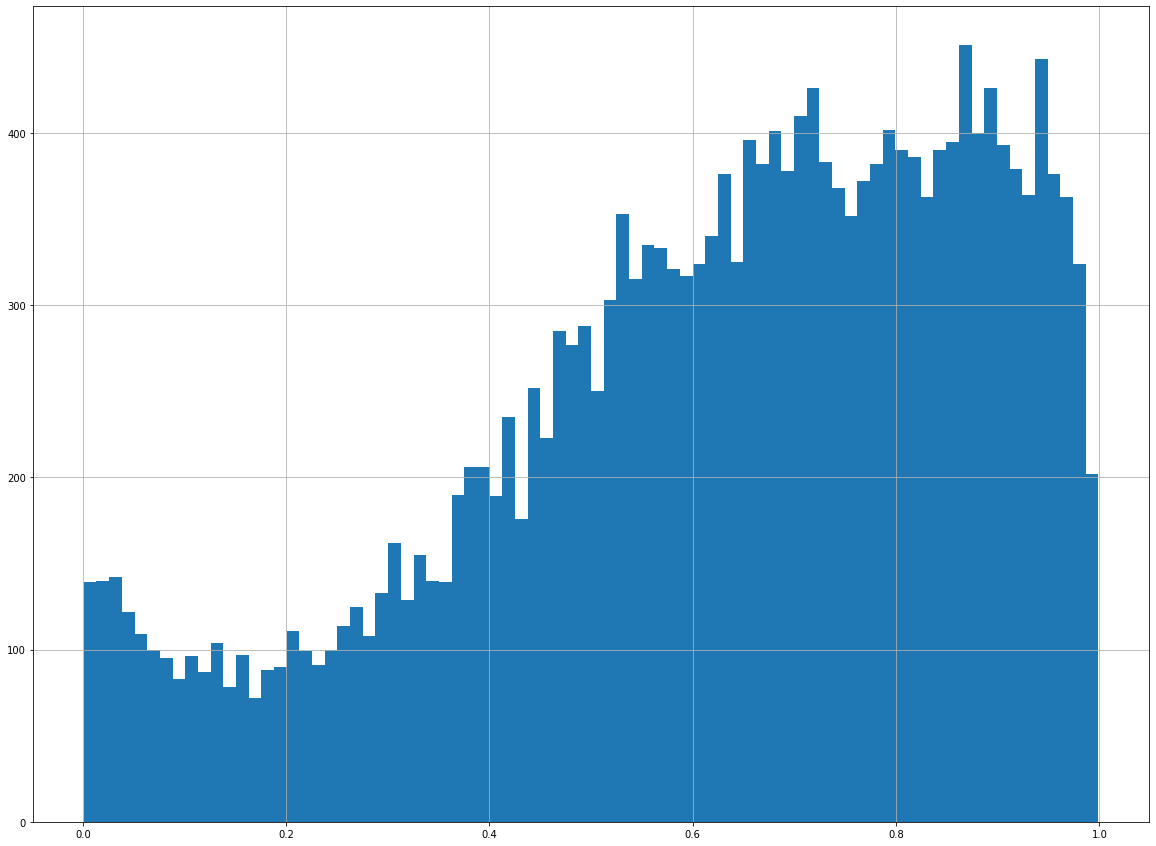

In [23]:
print(df['energy'].hist(bins=80, figsize=(20, 15)))
print(df['energy'].describe())

Значения этой переменной находятся в промежутке от 0 до 1. Оставляем переменную в этом виде.

### instrumentalness

AxesSubplot(0.125,0.125;0.775x0.755)
count    20364.000000
mean         0.159263
std          0.305963
min          0.000000
25%          0.000000
50%          0.000142
75%          0.082425
max          0.996000
Name: instrumentalness, dtype: float64


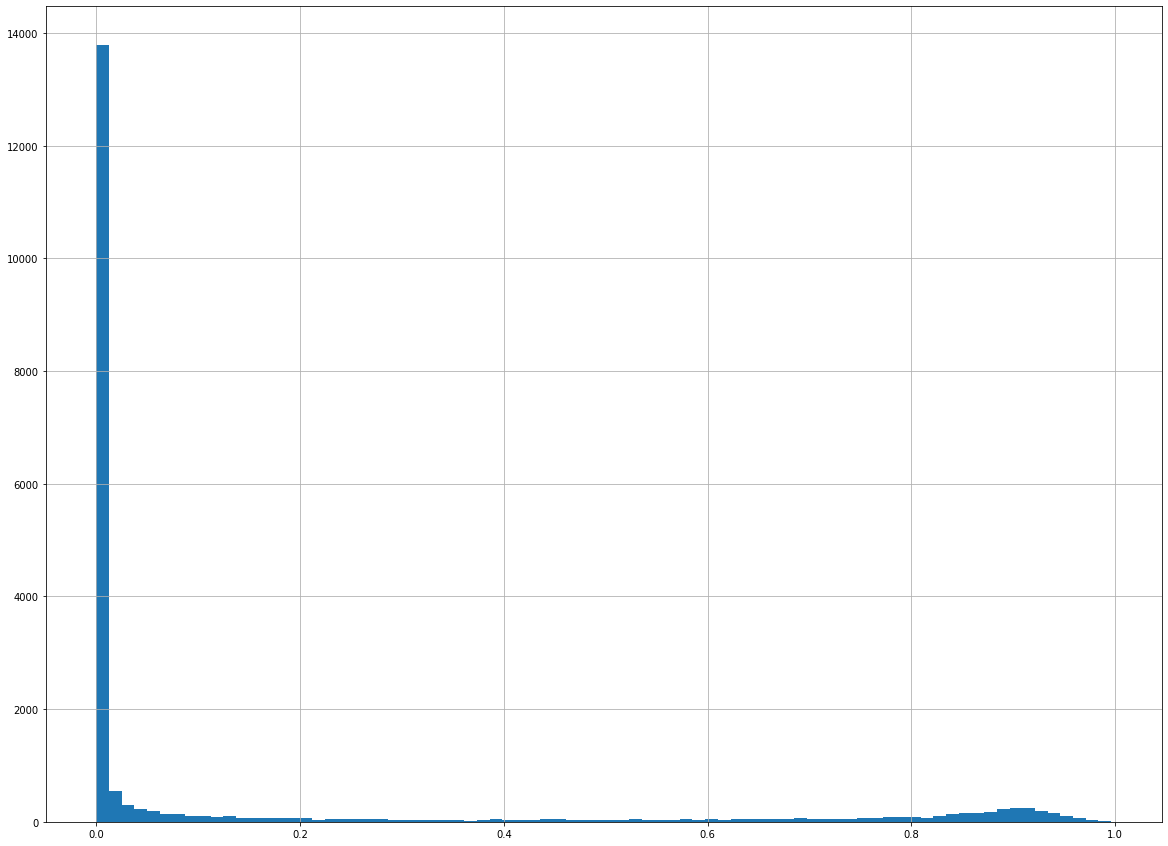

In [24]:
print(df['instrumentalness'].hist(bins=80, figsize=(20, 15)))
print(df['instrumentalness'].describe())

Здесь также видим значения от 0 до 1, переменную не трогаем.

### key

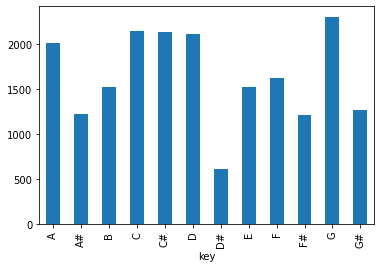

In [25]:
df.groupby('key')['key'].count().plot(kind='bar');

Ключ произведения - категориальный признак. Чтобы не заполнять пропуски ошибочной информацией, создадим для пропусков отдельную категорию - 'Other' (в следующем разделе).

### liveness

AxesSubplot(0.125,0.125;0.775x0.755)
count    20364.000000
mean         0.198451
std          0.166563
min          0.013600
25%          0.097300
50%          0.130000
75%          0.253000
max          1.000000
Name: liveness, dtype: float64


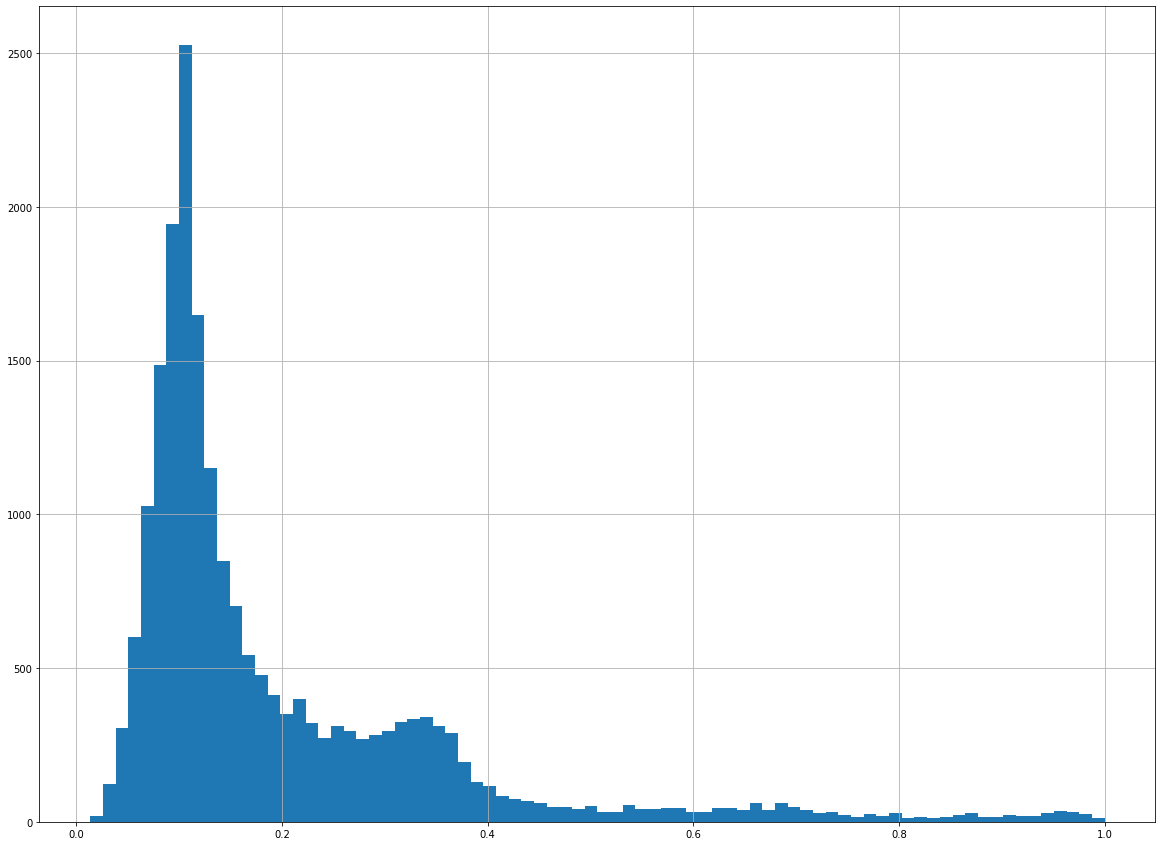

In [26]:
print(df['liveness'].hist(bins=80, figsize=(20, 15)))
print(df['liveness'].describe())

Значения находятся в промежутке от 0 до 1, оставляем в том виде, в каком сейчас переменная.

### loudness

AxesSubplot(0.125,0.125;0.775x0.755)
count    20364.000000
mean        -8.543935
std          5.494712
min        -44.406000
25%        -10.243000
50%         -7.046000
75%         -5.052000
max          3.744000
Name: loudness, dtype: float64


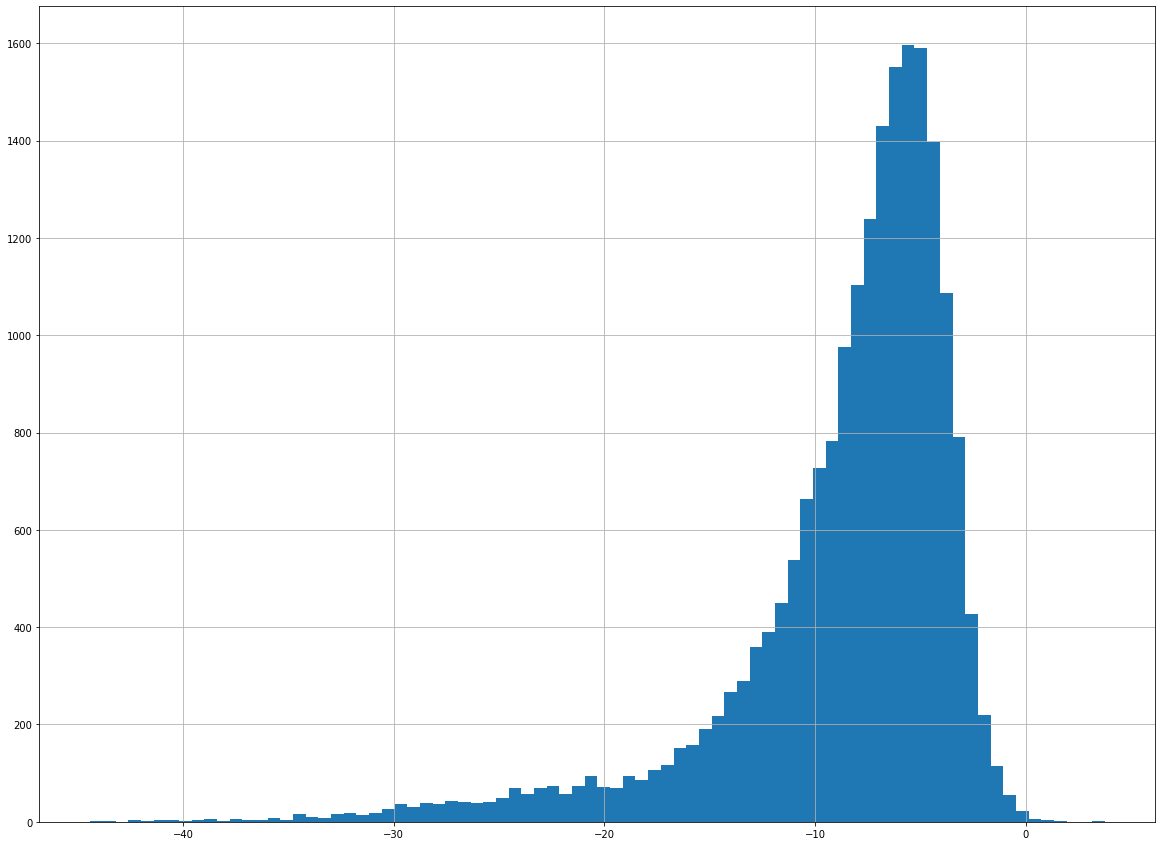

In [27]:
print(df['loudness'].hist(bins=80, figsize=(20, 15)))
print(df['loudness'].describe())

Громкость измеряется и положительными величинами, и отрицательными. Переменную не трогаем.

### mode

<AxesSubplot:xlabel='mode'>

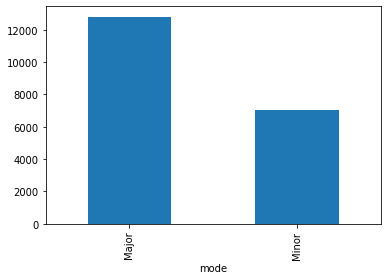

In [28]:
df.groupby('mode')['mode'].count().plot(kind='bar')

Тональность бывает мажорная и минорная, все верно.

### speechiness

AxesSubplot(0.125,0.125;0.775x0.755)
count    20364.000000
mean         0.091409
std          0.097790
min          0.022300
25%          0.035600
50%          0.049100
75%          0.095800
max          0.942000
Name: speechiness, dtype: float64


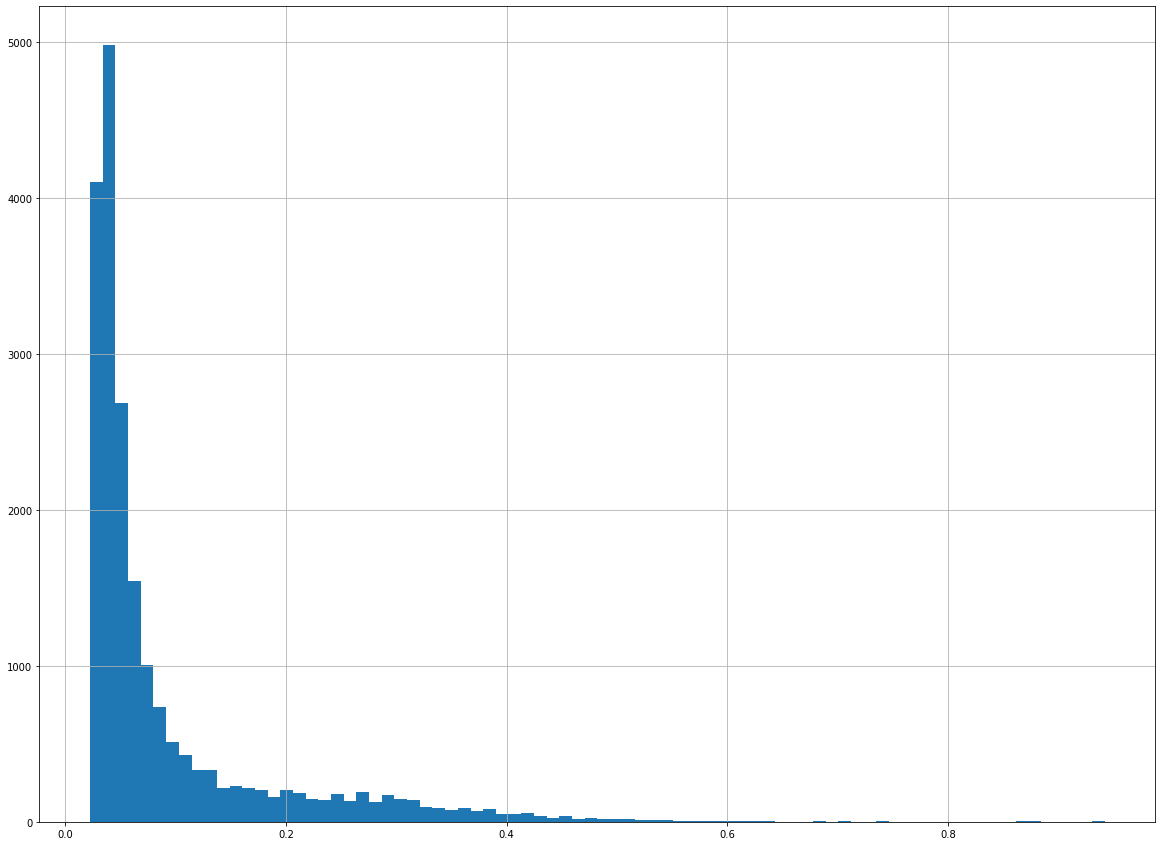

In [29]:
print(df['speechiness'].hist(bins=80, figsize=(20, 15)))
print(df['speechiness'].describe())

(0.15, 0.6)

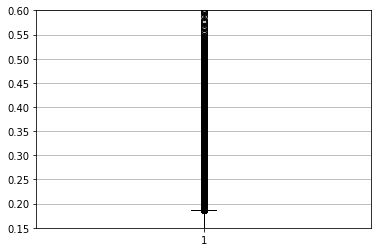

In [30]:
plt.boxplot(x=df['speechiness'])
plt.grid(True)
plt.ylim(0.15, 0.6)

In [31]:
df.query('speechiness > 0.30').count()

acousticness        1189
danceability        1189
duration_ms         1189
energy              1189
instrumentalness    1189
key                 1148
liveness            1189
loudness            1189
mode                1159
speechiness         1189
tempo               1164
valence             1189
music_genre         1189
symbol_count        1189
dtype: int64

In [32]:
#удалим выбросы в speechiness
df = df.query('speechiness < 0.55')

Переменная, связанная с речью в треках находится в промежутке от 0 до 1. Видно много отличающихся от среднего значений. Удалим значения, меньшие 0.55. Это самые высокие выбросы.

### tempo

AxesSubplot(0.125,0.125;0.775x0.755)
count    19867.000000
mean       120.981834
std         30.380682
min         34.765000
25%         95.967000
50%        120.015000
75%        141.962500
max        220.041000
Name: tempo, dtype: float64


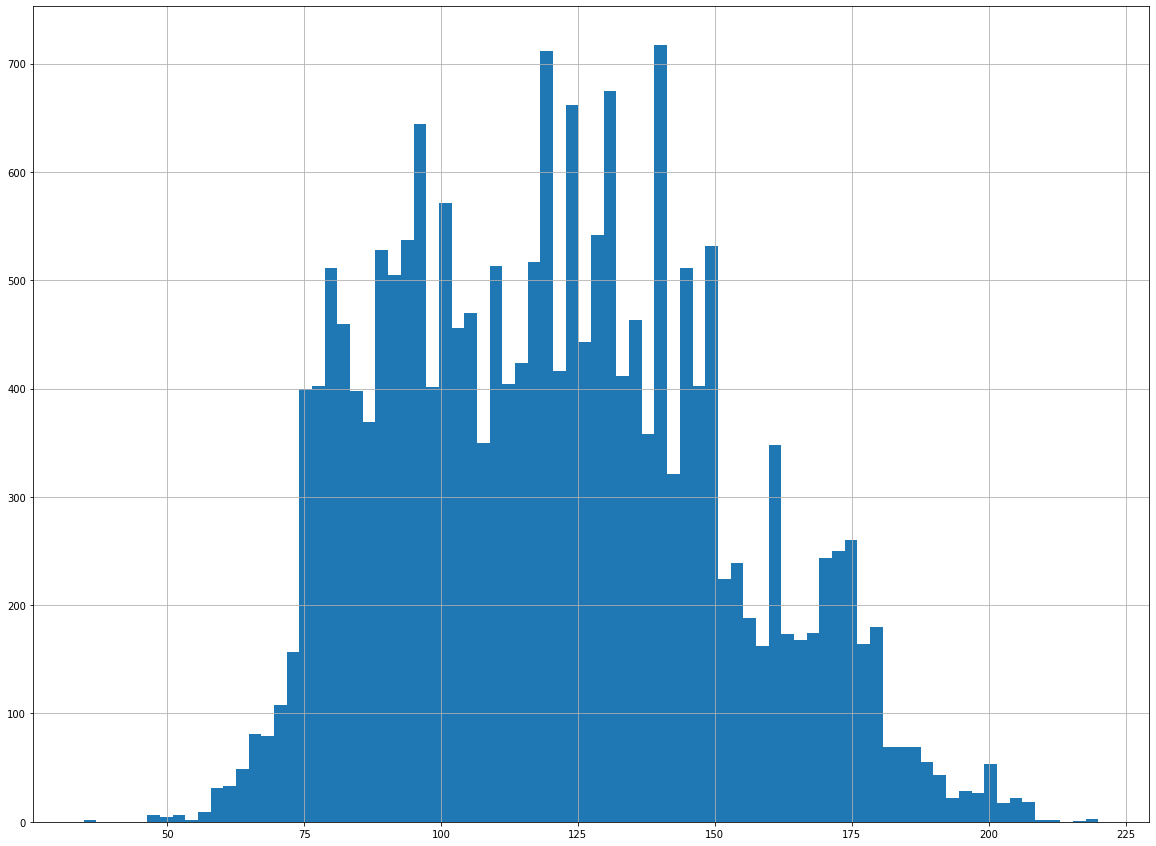

In [33]:
print(df['tempo'].hist(bins=80, figsize=(20, 15)))
print(df['tempo'].describe())

In [34]:
df.query('tempo > 208').count()

acousticness        11
danceability        11
duration_ms         11
energy              11
instrumentalness    11
key                 10
liveness            11
loudness            11
mode                11
speechiness         11
tempo               11
valence             11
music_genre         11
symbol_count        11
dtype: int64

In [35]:
#удалим выбросы в tempo
df = df.query('tempo < 208')

Оставим только наблюдения, темп которых меньше 208.

### valence

AxesSubplot(0.125,0.125;0.775x0.755)
count    19856.000000
mean         0.465001
std          0.243157
min          0.000000
25%          0.273000
50%          0.458000
75%          0.653000
max          0.992000
Name: valence, dtype: float64


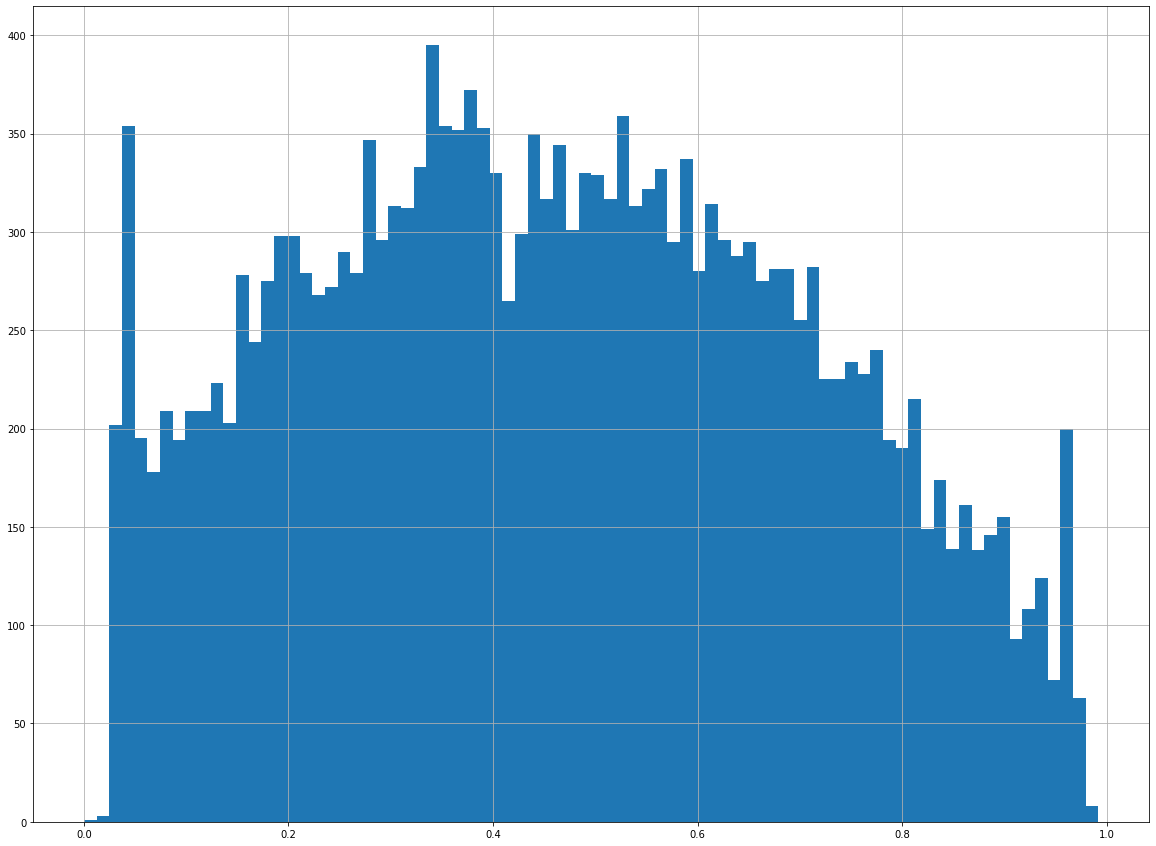

In [36]:
print(df['valence'].hist(bins=80, figsize=(20, 15)))
print(df['valence'].describe())

Привлекательность произведения для пользователей сервиса находится в промежутке от 0 до 1. Не трогаем переменную.

### music_genre - целевой признак

<AxesSubplot:xlabel='music_genre'>

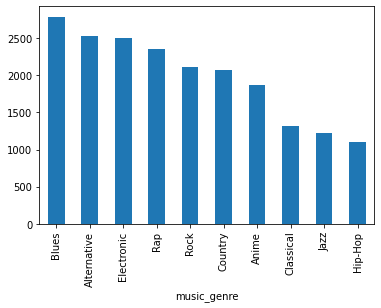

In [37]:
df.groupby('music_genre')['acousticness'].count().sort_values(ascending=False).plot(kind='bar')

Целевой признак - музыкальный жанр - это категориальная переменная. Всего 10 жанров.
Заметен дисбаланс между разными классами. Треков жанра хип-хоп почти в 2 раза меньше, чем треков жанра блюз.

Далее будем учитывать этот дисбалан при разделении выборки, а также подбирая гиперпараметры моделей.

## Корреляция между признаками

Посмотрим, насколько связаны рассматриваемые признаки. Сначала посмтрим на переменные визуально:

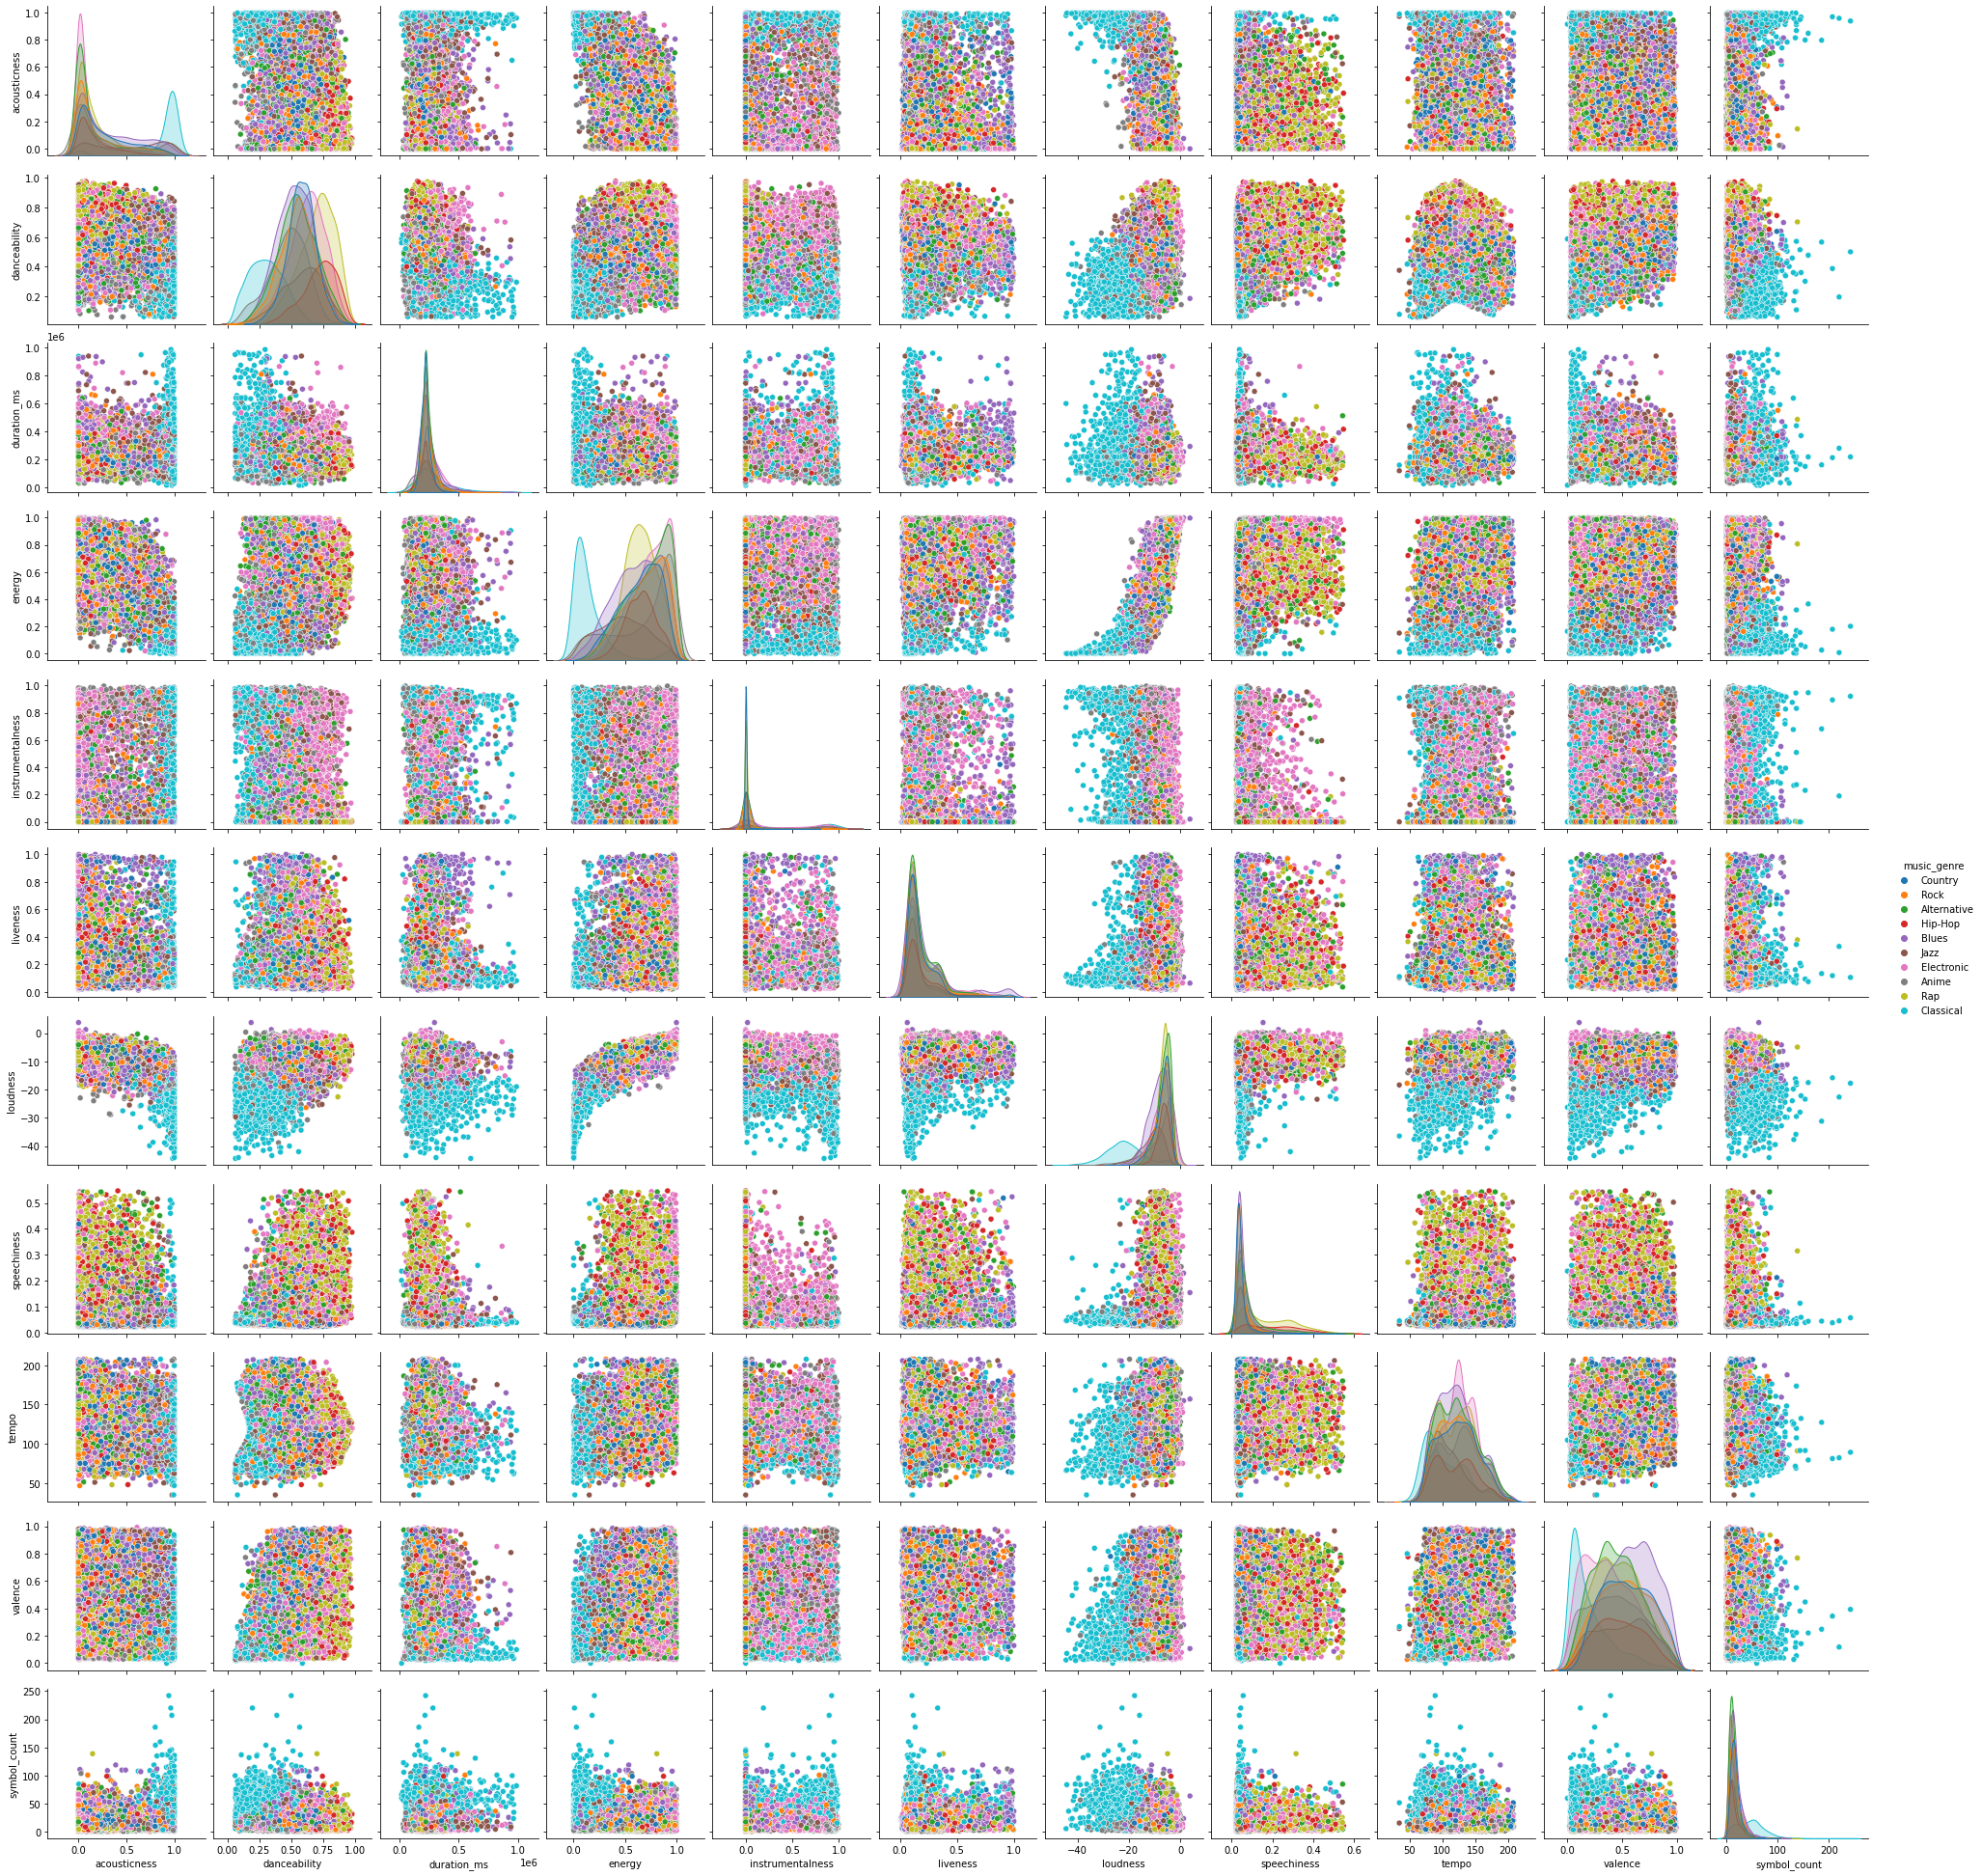

In [38]:
sns.pairplot(df, hue='music_genre');

Каких-то ярких закономерностей не видно. Только между переменными энергичность и громкость.

Построим матрицу корреляции с помощью библиотеки Phik.

In [39]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'symbol_count']


acousticness  danceability  duration_ms  energy  \
acousticness              1.00          0.46         0.25    0.77   
danceability              0.46          1.00         0.28    0.52   
duration_ms               0.25          0.28         1.00    0.27   
energy                    0.77          0.52         0.27    1.00   
instrumentalness          0.44          0.34         0.33    0.44   
key                       0.10          0.10         0.04    0.09   
liveness                  0.19          0.13         0.13    0.26   
loudness                  0.71          0.48         0.32    0.84   
mode                      0.03          0.11         0.05    0.04   
speechiness               0.25          0.36         0.12    0.32   
tempo                     0.32          0.40         0.12    0.37   
valence                   0.40          0.53         0.24    0.48   
music_genre               0.66          0.62         0.38    0.67   
symbol_count              0.43          0.28         0.23    0.42   

                  instrumentalness   key  liveness  loudness  mode  \
acousticness                  0.44  0.10      0.19      0.71  0.03   
danceability                  0.34  0.10      0.13      0.48  0.11   
duration_ms                   0.33  0.04      0.13      0.32  0.05   
energy                        0.44  0.09      0.26      0.84  0.04   
instrumentalness              1.00  0.03      0.14      0.50  0.09   
key                           0.03  1.00      0.06      0.08  0.36   
liveness                      0.14  0.06      1.00      0.20  0.03   
loudness                      0.50  0.08      0.20      1.00  0.02   
mode                          0.09  0.36      0.03      0.02  1.00   
speechiness                   0.21  0.13      0.14      0.25  0.13   
tempo                         0.20  0.05      0.08      0.34  0.01   
valence                       0.35  0.04      0.13      0.43  0.06   
music_genre                   0.57  0.17      0.21      0.68  0.30   
symbol_count                  0.22  0.03      0.12      0.46  0.02   

                  speechiness  tempo  valence  music_genre  symbol_count  
acousticness             0.25   0.32     0.40         0.66          0.43  
danceability             0.36   0.40     0.53         0.62          0.28  
duration_ms              0.12   0.12     0.24         0.38          0.23  
energy                   0.32   0.37     0.48         0.67          0.42  
instrumentalness         0.21   0.20     0.35         0.57          0.22  
key                      0.13   0.05     0.04         0.17          0.03  
liveness                 0.14   0.08     0.13         0.21          0.12  
loudness                 0.25   0.34     0.43         0.68          0.46  
mode                     0.13   0.01     0.06         0.30          0.02  
speechiness              1.00   0.21     0.14         0.52          0.05  
tempo                    0.21   1.00     0.26         0.32          0.12  
valence                  0.14   0.26     1.00         0.46          0.20  
music_genre              0.52   0.32     0.46         1.00          0.50  
symbol_count             0.05   0.12     0.20         0.50          1.00

И визуализируем ее:

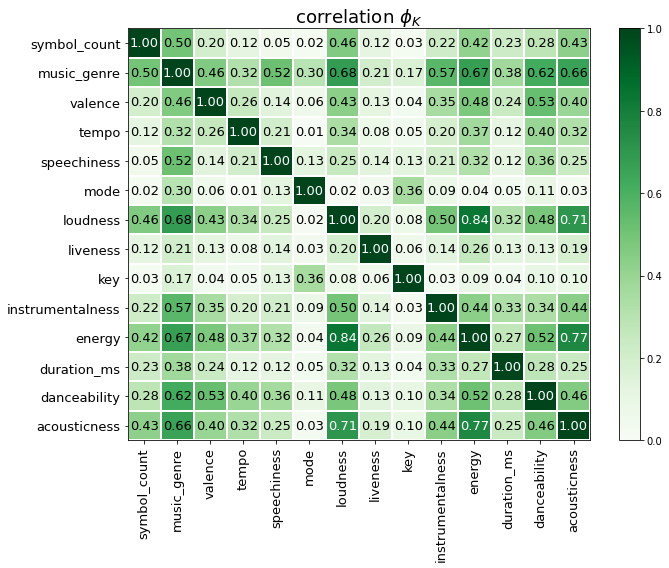

In [40]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.3,
                        figsize=(10, 8))
plt.tight_layout()

Громкость и энергичность действительно имеют самый высокий коэффициент корреляции среди представленных переменных.

Также высокие коэффициенты между целевым признаком (жанры произведений) и акустичностью, танцевальностью, энергичностью, громкостью и инструментальностью. Все эти связи статистически значимы (см.ниже).

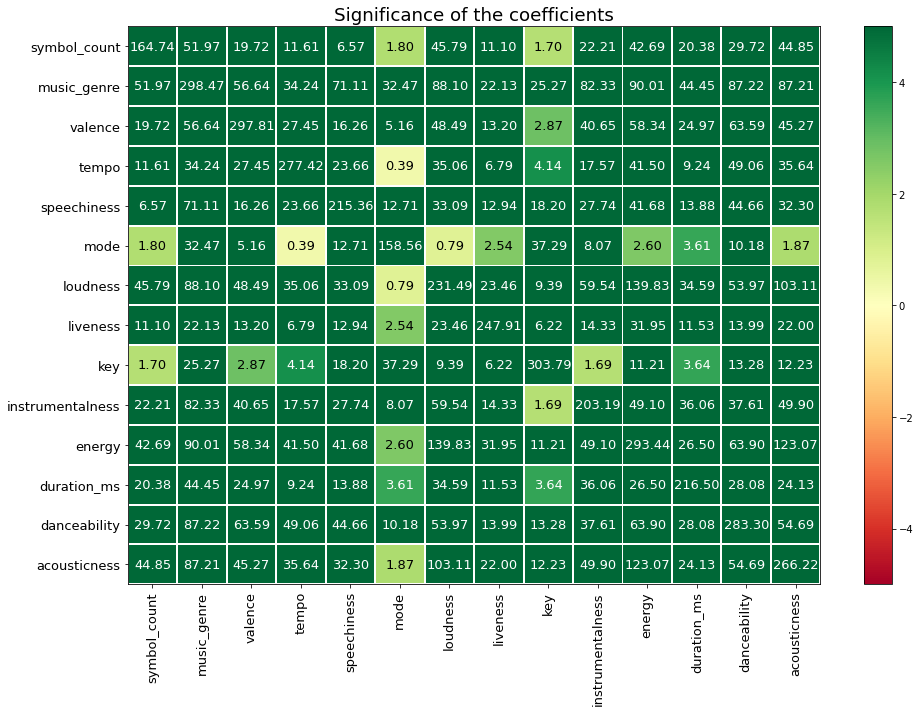

In [41]:
interval_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-5, vmax=5, title="Significance of the coefficients",
                        usetex=False, fontsize_factor=1.3, figsize=(14, 10))
plt.tight_layout()

Посмотрим общий коэффициент корреляции - какие переменные наибольшим образом связаны с другими.

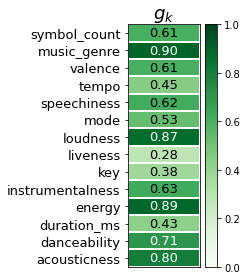

In [42]:
global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation,
                        x_labels=[''], y_labels=global_labels,
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.3)
plt.tight_layout()

Музыкальный жанр (целевая переменная), громкость, энергичность и акустичность в большей степени корреляруют с другими переменными.

## Пропущенные значения

Запоним пропуски в числовом признаке 'tempo' медианным значением по жанрам:

In [43]:
df['tempo'] = df['tempo'].fillna(df.groupby('music_genre')['tempo'].transform('median'))
df_test['tempo'] = df_test['tempo'].fillna(df.groupby('music_genre')['tempo'].transform('median'))

Пропущенные значения в категориальных признаках заполним новой категорией "Другое". Обучающая выборка:

In [44]:
df['key'] = df['key'].fillna('Other')
df['mode'] = df['mode'].fillna('Other')

Тестовая выборка:

In [45]:
df_test['key'] = df_test['key'].fillna('Other')
df_test['mode'] = df_test['mode'].fillna('Other')

## Вывод

В данном разделе были загружены базы данных, удалены аномальные значения, заполнены пропуски. Также были отобраны признаки для анализа и проверена их корреляция.

# Построение моделей

Построим три модели (RandomForestClassifier - случайный лес, LGBMClassifier на основе градиентного бустинга и CatBoostClassifier), подберем параметры с помощью кросс-валидации (RandomizedSearchCV) и посмотрим на лучшую метрику f1-micro.

## Разделение на выборки

Перекодируем целевой признак:

In [46]:
le = LabelEncoder()
le.fit(df['music_genre'])
le.classes_
music_genre_transform = le.transform(df['music_genre'])
music_genre_transform

array([4, 9, 0, ..., 0, 8, 5])

Разделим обучающую выборку на две - обучающую и валидационную (10%). Так как у нас есть дисбаланс в целевом признаке, при разбиении укажем параметр stratify.

In [47]:
target = music_genre_transform
features = df.drop('music_genre', axis=1)

In [48]:
features_train, features_valid, target_train, target_valid \
= train_test_split(features, target, test_size=0.1, random_state=12345, stratify=target)

In [49]:
print('features_train:')
print(features_train.shape[0])

print('features_valid:')
print(features_valid.shape[0])

features_train:
17870
features_valid:
1986


Выделим категориальные и числовые признаки:

In [50]:
cat_columns = features.select_dtypes(include='object').columns.tolist()
num_columns = features.select_dtypes(include=['float64', 'int64']).columns.tolist()

## RandomForestClassifier

Проведем обработку данных и построим модели с помощью pipeline. Обработка столбцов будет одинаковой для всех моделей:

In [51]:
column_transformer = make_column_transformer((StandardScaler(), num_columns),
                                             (OneHotEncoder(drop='first'), cat_columns),
                                              remainder='passthrough')

In [52]:
model_forest = RandomForestClassifier(random_state=1234)
pipeline_forest = make_pipeline(column_transformer, model_forest)
pipeline_forest

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence', 'symbol_count']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['key', 'mode'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=1234))])

Параметры

In [53]:
params_forest = {'randomforestclassifier__n_estimators': range(10, 100),
                 'randomforestclassifier__max_depth': range(2, 15)
         }

In [54]:
%%time

randomdearch_forest = RandomizedSearchCV(pipeline_forest, params_forest, cv=5, scoring='f1_micro', random_state=12345)
randomdearch_forest.fit(features_train, target_train)

print('f1-micro:', randomdearch_forest.best_score_)
print('Лучшие параметры модели:', randomdearch_forest.best_params_)

f1-micro: 0.4711807498601007
Лучшие параметры модели: {'randomforestclassifier__n_estimators': 59, 'randomforestclassifier__max_depth': 10}
CPU times: user 46.8 s, sys: 57.4 ms, total: 46.9 s
Wall time: 47.4 s


## LGBMClassifier

In [55]:
model = LGBMClassifier(random_state=1234)
pipeline = make_pipeline(column_transformer, model)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence', 'symbol_count']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['key', 'mode'])])),
                ('lgbmclassifier', LGBMClassifier(random_state=1234))])

In [56]:
params = {'lgbmclassifier__n_estimators': range(10, 100),
          'lgbmclassifier__objective': ['multiclass', 'multiclassova'],
          'lgbmclassifier__max_depth': range(2, 20),
          'lgbmclassifier__subsample_for_bin': [200000, 300000],
          'lgbmclassifier__verbose': [-1]
         }

In [57]:
%%time

randomsearch = RandomizedSearchCV(pipeline, params, cv=5, scoring='f1_micro', random_state=12345)
randomsearch.fit(features_train, target_train)

print('f1-micro:', randomsearch.best_score_)
print('Лучшие параметры модели:', randomsearch.best_params_)

f1-micro: 0.4824846110800224
Лучшие параметры модели: {'lgbmclassifier__verbose': -1, 'lgbmclassifier__subsample_for_bin': 200000, 'lgbmclassifier__objective': 'multiclassova', 'lgbmclassifier__n_estimators': 43, 'lgbmclassifier__max_depth': 13}
CPU times: user 10min 8s, sys: 4.2 s, total: 10min 12s
Wall time: 10min 16s


## CatBoostClassifier

In [58]:
model_cat = CatBoostClassifier(random_state=1234)
pipeline_cat = make_pipeline(column_transformer, model_cat)
pipeline_cat

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence', 'symbol_count']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['key', 'mode'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f62c513ad90>)])

In [59]:
params_cat = {'catboostclassifier__iterations': range(10, 100),
              'catboostclassifier__depth': range(2, 15),
              'catboostclassifier__verbose': [False]
         }

In [60]:
%%time

randomsearch_cat = RandomizedSearchCV(pipeline_cat, params_cat, cv=5, scoring='f1_micro', random_state=12345)
randomsearch_cat.fit(features_train, target_train)

print('f1-micro:', randomsearch_cat.best_score_)
print('Лучшие параметры модели:', randomsearch_cat.best_params_)

f1-micro: 0.47000559597090097
Лучшие параметры модели: {'catboostclassifier__verbose': False, 'catboostclassifier__iterations': 49, 'catboostclassifier__depth': 3}
CPU times: user 1h 3min 41s, sys: 1h 1min 2s, total: 2h 4min 44s
Wall time: 2h 5min 25s


## Проверка на валидационной выборке

In [61]:
lgbm_valid = randomsearch.predict(features_valid)
result_f1 = f1_score(target_valid, lgbm_valid, average='micro')
print('F1 на валидационной выборке:', result_f1)

F1 на валидационной выборке: 0.473313192346425


На валидационной выборке (10% от исходного датасета) качество модели немного хуже, чем на тренировочной. Разница в 1% не очень велика, поэтому можно сказать, что модель работает стабильно.

## Важность признаков

Посмотрим, какие признаки наиболее важны при определении целевой переменной - музыкального жанра.

In [62]:
pipeline.fit(features_train, target_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence', 'symbol_count']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['key', 'mode'])])),
                ('lgbmclassifier', LGBMClassifier(random_state=1234))])

In [63]:
feature_importance = pipeline.named_steps['lgbmclassifier'].feature_importances_
feature_names = column_transformer.get_feature_names_out()
features_model_lgbm = pd.DataFrame(feature_names, feature_importance)
features_model_lgbm.columns = ['features_names']
features_model_lgbm.sort_index(ascending=False)

features_names
3090      standardscaler__danceability
2889       standardscaler__speechiness
2807           standardscaler__valence
2758      standardscaler__acousticness
2709       standardscaler__duration_ms
2550             standardscaler__tempo
2531          standardscaler__loudness
2378            standardscaler__energy
2343  standardscaler__instrumentalness
2342          standardscaler__liveness
2124      standardscaler__symbol_count
300          onehotencoder__mode_Minor
133              onehotencoder__key_C#
107              onehotencoder__key_G#
103               onehotencoder__key_G
103               onehotencoder__key_C
99               onehotencoder__key_A#
95               onehotencoder__key_F#
94                onehotencoder__key_E
93                onehotencoder__key_D
92                onehotencoder__key_B
71                onehotencoder__key_F
68           onehotencoder__mode_Other
65            onehotencoder__key_Other
56               onehotencoder__key_D#

Высокое значение важности означает, что значение признака вносит большой вклад в определение музыкального жанра.

Можно заметить, что категориальные признаки - тональность и ключ - практически не играют роли в определении целевой переменной. Наиболее значимы - количественные признаки.

На первом месте - danceability(танцевальность). Далее идут speechiness(выразительность), valence(привлекательность произведения для пользователей сервиса), acousticness(акустичность), duration_ms(длительность в миллисекундах).

Интересно, что новый созданный признак - длина названия трека(symbol_count) - тоже вносит достаточный вклад в классификацию музыки.

## Вывод

Было рассмотрено три модели, они показали примерно одинаковое качество - 0.471-0.482. Лучшее качество у LGBMClassifier - 0.482, худшее - у CatBoostClassifier - 0.47.

Параметры лучшей модели LGBMClassifier:

{'subsample_for_bin': 200000,

'objective': 'multiclassova',

'n_estimators': 43,

'max_depth': 13}

На валидационной выборке качество получилось на 1% хуже, чем на тренировочной. Это значит, что модель работает стабильно и ее можно использовать.

Самые важные признаки, которые влияют на целевую переменную, это:  danceability(танцевальность), speechiness(выразительность), valence(привлекательность произведения для пользователей сервиса), acousticness(акустичность), duration_ms(длительность в миллисекундах)

# Предсказания на тестовой выборке

Решим поставленную задачу - классифицируем треки, представленные в тестовой базе.

In [64]:
features_test = df_test
lgbm_model_predictions_test = randomsearch.predict(features_test)

In [65]:
lgbm_model_predictions_test = pd.DataFrame(data=lgbm_model_predictions_test)
test_result = pd.concat([df_test, df_test_id, lgbm_model_predictions_test], axis=1)
test_result.head()

acousticness  danceability  duration_ms  energy  instrumentalness key  \
0      0.301000         0.757     146213.0   0.679           0.00000  A#   
1      0.538000         0.256     240360.0   0.523           0.00832  G#   
2      0.005830         0.678     284000.0   0.770           0.00000   A   
3      0.020300         0.592     177354.0   0.749           0.00000   B   
4      0.000335         0.421         -1.0   0.447           0.01480   D   

   liveness  loudness   mode  speechiness    tempo  valence  symbol_count  \
0    0.3030    -7.136  Minor       0.3560   90.361    0.895            20   
1    0.0849    -5.175  Major       0.0294   78.385    0.318            10   
2    0.1090    -4.399  Minor       0.2220   90.000    0.412            11   
3    0.1220    -4.604  Major       0.0483  160.046    0.614            18   
4    0.0374    -8.833  Major       0.2020   73.830    0.121            10   

   instance_id  0  
0        48564  8  
1        72394  9  
2        88081  8  
3        78331  4  
4        72636  8

In [66]:
test_result = pd.DataFrame(test_result)
test_result = test_result.iloc[:, [13, 14]]
test_result.columns = ['instance_id', 'music_genre']
test_result['music_genre'] = le.inverse_transform(test_result['music_genre'])
test_result.head()

instance_id music_genre
0        48564         Rap
1        72394        Rock
2        88081         Rap
3        78331     Country
4        72636         Rap

Выше - часть итоговой таблицы. Значение F1- mini равно 0.47764, что близко к показателю, значит, модель работает достаточно стабильно.

# Вывод

Сначала были загружены базы данных, удалены аномальные значения, заполнены пропуски. Также были отобраны признаки для анализа и проверена их корреляция.

Было рассмотрено три модели, они показали примерно одинаковое качество метрики F1-микро - 0.471-0.482. Лучшее качество у модели LGBMClassifier - 0.482.

На валидационной выборке качество получилось на 1% хуже, чем на тренировочной. Это значит, что модель работает стабильно и ее можно использовать.

Это показала и тестовая выборка, метрика F1-микро на которой равна 0.477, что примерно на 0.5% хуже, чем показала тренировочная выборка.

Самые важные признаки, которые влияют на целевую переменную, это: danceability(танцевальность), speechiness(выразительность), valence(привлекательность произведения для пользователей сервиса), acousticness(акустичность), duration_ms(длительность в миллисекундах).